In [1]:
%load_ext cypher

In [2]:
%%cypher
MATCH (n)
OPTIONAL MATCH (n)-[r]-()
DELETE n,r

1 relationship deleted.
4 nodes deleted.


[]

In [3]:
%cypher CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE

1 constraints added.


[]

In [4]:
%cypher CREATE CONSTRAINT ON (u:User) ASSERT u.username IS UNIQUE

1 constraints added.


[]

In [5]:
%cypher CREATE CONSTRAINT ON (h:HashTag) ASSERT h.hashtag IS UNIQUE

1 constraints added.


[]

![png](./images/Model.png)

In [6]:
from pprintpp import pprint as pp


In [7]:
from py2neo import Graph, Relationship
import json

graph = Graph()

In [8]:
def add_property(obj, json, name):
    if name in json:
        obj[name] = json[name]

In [9]:
def parse_user(user_json):
    user = graph.merge_one("User", "username", user_json['screen_name'])
    
    add_property(user, user_json, 'created_at')
    add_property(user, user_json, 'description')
    add_property(user, user_json, 'favourites_count')
    add_property(user, user_json, 'followers_count')
    add_property(user, user_json, 'friends_count')
    add_property(user, user_json, 'statuses_count')
    add_property(user, user_json, 'time_zone')
    add_property(user, user_json, 'name')
    add_property(user, user_json, 'profile_image_url')
    
    user.push()
    return user

In [10]:
def parse_tweet(tweet_json):
    user = parse_user(tweet_json['user'])
    
    tweet = graph.merge_one("Tweet", "id", tweet_json['id'])
    add_property(tweet, tweet_json, 'created_at')
    add_property(tweet, tweet_json, 'lang')
    add_property(tweet, tweet_json, 'retweet_count')
    add_property(tweet, tweet_json, 'source')
    add_property(tweet, tweet_json, 'text')
    
    tweet.push()
    
    user_tweeted_tweet = Relationship(user, "TWEETED", tweet)
    graph.create_unique(user_tweeted_tweet)
    
    if 'user_mentions' in tweet_json:
        for user_mention_json in tweet_json['user_mentions']:
            user_mencioned = parse_user(user_mention_json)
            tweet_mencioned_user = Relationship(tweet, "MENCIONED", user_mencioned)
            graph.create_unique(tweet_mencioned_user)
 
    if 'entities' in tweet_json:
        for entity in tweet_json['entities']:
            hashtag = graph.merge_one("HashTag", "hashtag", entity)
            tweet_HashTag_hashtag = Relationship(tweet, "HASHTAG", hashtag)
            graph.create_unique(tweet_HashTag_hashtag)

    if 'retweeted_status' in tweet_json:
        user_retweeted = parse_user(tweet_json['retweeted_status']['user'])
        tweet_retweetOf_user = Relationship(tweet, "RETWEET_OF", user_retweeted)
        graph.create_unique(tweet_retweetOf_user)
        
        parse_tweet(tweet_json['retweeted_status'])

In [11]:
def load_file(tweets_data_path):
    tweets_file = open(tweets_data_path, "r")
    for tweet in tweets_file:
        parse_tweet(json.loads(tweet))

In [12]:
load_file('../data/tweets.json')

In [13]:
%%cypher
MATCH p = ((u:User {username : 'couchbase'})-[r:TWEETED]->t)
RETURN u.username, t.text, type(r)
LIMIT 10

10 rows affected.


u.username,t.text,type(r)
couchbase,Want to quickly learn to build #NoSQL applications? Get FREE online training today: https://t.co/pPYZvZdqDi https://t.co/9DFR3yTTfL,TWEETED
couchbase,RT @arungupta: Blogged: Why Couchbase over MongoDB? #SayNoToMongoDB: MongoDB is one of the most popular NoSQL databases. Its ... https://t.…,TWEETED
couchbase,Top 5 reasons to secure #NoSQL deployments. Protect data using #Vormetric's Data Security platform for #Couchbase: https://t.co/tDnyyUzayz,TWEETED
couchbase,"Download #Couchbase 4.0 and build apps using #SQL for #JSON. Fast, efficient, powerful query http://t.co/Xt8cpz7Ffk #database #developers",TWEETED
couchbase,#CBLiveNY presentations &amp; videos are now posted. Learn about the latest innovations in 4.0 &amp; #N1QL. Watch now: https://t.co/1lXyLtUbNV,TWEETED
couchbase,Want to quickly learn to build #NoSQL applications? Get FREE online training today: http://t.co/pPYZvZdqDi http://t.co/62jJwTR7AI,TWEETED
couchbase,Missed #CBLiveNY or just want to revisit the great presentations? Slides are posted: http://t.co/SJB6CMRkSU #Couchbase #NoSQL #N1QL,TWEETED
couchbase,"Download #Couchbase 4.0 and build apps using #SQL for #JSON. Fast, efficient, powerful query https://t.co/Xt8cpzpgDU #database #developers",TWEETED
couchbase,From Cache to Query: CenterEdge tells @diginomica about how Black Friday performances prompted the switch to #NoSQL https://t.co/SAWZEPtIJI,TWEETED
couchbase,"Sign up in Oslo, Helsinki &amp; Stockholm next month &amp; get FREE expert #bigdata training. Get developer agility w/ JSON https://t.co/4gjNQgHXkd",TWEETED


In [14]:
%%cypher match (n:HashTag)-[r]-() 
return n.hashtag, count(r) as degree 
order by degree desc
limit 10

10 rows affected.


n.hashtag,degree
NoSQL,1230
BigData,574
Java,531
MongoDB,502
Hadoop,469
nosql,426
SoapUi,408
hive,310
bigdata,176
MongoDb,112


In [15]:
%matplotlib inline

In [16]:
results = %%cypher match (n:HashTag)-[r]-()  return n.hashtag as HashTag, count(r) as Degree order by Degree desc limit 10

10 rows affected.


In [17]:
results.get_dataframe()

,HashTag,Degree
0,NoSQL,1230
1,BigData,574
2,Java,531
3,MongoDB,502
4,Hadoop,469
5,nosql,426
6,SoapUi,408
7,hive,310
8,bigdata,176
9,MongoDb,112


([<matplotlib.patches.Wedge at 0x7fd109d439d0>,
  <matplotlib.text.Text at 0x7fd109fbd6d0>])

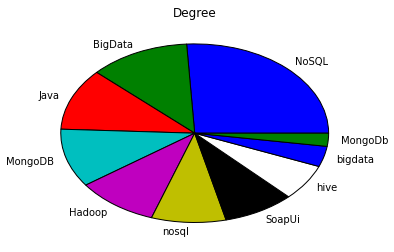

In [18]:
results.pie()

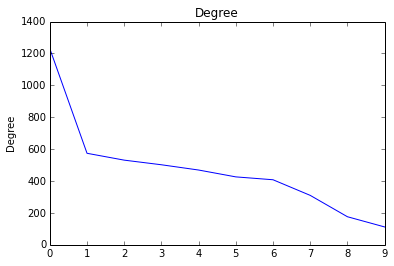

In [19]:
results.plot()

<Container object of 10 artists>

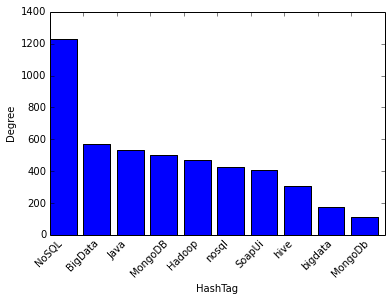

In [20]:
results.bar()

10 rows affected.


(<networkx.classes.multidigraph.MultiDiGraph at 0x7fd109b36ad0>,
 <matplotlib.collections.PathCollection at 0x7fd109d69710>)

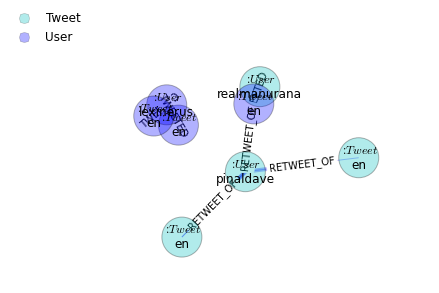

In [21]:
results = %cypher match (n)-[r]-() return n, r limit 10
results.draw()

In [22]:
from py2neo import Graph
graph = Graph()
cypher = graph.cypher

In [23]:
query = """
    MATCH (h:HashTag)<-[:HASHTAG]-(:Tweet)-[:HASHTAG]->(HashTag {hashtag:"neo4j"}) 
    WHERE h.hashtag <> "neo4j"
    RETURN h.hashtag AS hashtag, COUNT(*) AS count
    ORDER BY count DESC
    LIMIT 10
"""

results = cypher.execute(query )
print results



    | hashtag        | count
----+----------------+-------
  1 | nosql          |    19
  2 | hadoop         |     8
  3 | mongodb        |     8
  4 | spark          |     8
  5 | couchbase      |     8
  6 | redis          |     8
  7 | socialNetworks |     5
  8 | graphdb        |     5
  9 | nodejs         |     4
 10 | job            |     4



In [24]:
results = cypher.execute(
"""
MATCH (u:User)
WHERE exists(u.followers_count)
return distinct u.username, u.followers_count
order by u.followers_count DESC LIMIT 10
""")

print results

    | u.username     | u.followers_count
----+----------------+-------------------
  1 | googlecloud    |            447590
  2 | Azure          |            383977
  3 | craigbrownphd  |            368570
  4 | DavidPapp      |            215114
  5 | couchbase      |            160978
  6 | iamdevloper    |            125526
  7 | analyticbridge |            117146
  8 | docker         |             91037
  9 | javacodegeeks  |             79307
 10 | developerWorks |             75534



In [25]:
type(results)

py2neo.cypher.core.RecordList

In [26]:
%%cypher
MATCH (u:User)
WHERE exists(u.followers_count)
return distinct u.username, u.followers_count
order by u.followers_count DESC LIMIT 10

10 rows affected.


u.username,u.followers_count
googlecloud,447590
Azure,383977
craigbrownphd,368570
DavidPapp,215114
couchbase,160978
iamdevloper,125526
analyticbridge,117146
docker,91037
javacodegeeks,79307
developerWorks,75534


In [27]:
%%cypher
match n
return distinct labels(n)

3 rows affected.


labels(n)
[u'User']
[u'Tweet']
[u'HashTag']


In [28]:

result = %cypher MATCH (hashtag:HashTag)<-[:HASHTAG]-(tweet:Tweet) \
                 RETURN hashtag.name AS hashtag, COUNT(tweet) AS tweets \
                 ORDER BY tweets DESC LIMIT 5
        
df = result.get_dataframe()
df.head()

1 rows affected.


,hashtag,tweets
0,None,9382
